<a href="https://colab.research.google.com/github/JackLGood/Auto-Loan-Pricing-Optimization/blob/main/Auto_Loan_Pricing_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-Car's Business Model

e-Car runs a fully online auto-lending platform: borrowers apply via its site or partners (e.g., AutoCompare, LendingTree), supply personal, financial, and vehicle details, and are slotted into one of four risk bands and five term lengths. The firm then makes a single, non-negotiable offer—approve and quote an APR—aiming to maximize profit per loan without scaring the borrower off.

Because each extra segment multiplies the number of price points, e-Car supplements its band/term grid with small, controlled rate experiments to learn how acceptance rates change—and tweaks its APRs periodically in response to both those experiments and shifts in funding costs or competitive moves.

They constantly juggle 5 key uncertainties. First, default risk mis-measurement because FICO scores can lag real-world shocks—say, a sudden job loss or regional downturn—so actual loss rates may diverge from model estimates. Second borrowers can be price sensitive meaning willingness to pay can drift over time or differ by acquisition channel; past experiment results may not perfectly predict future take-rates. Third, e-Car doesn’t see manufacturer-subsidized dealer rates or last-minute cuts by rivals, which can undercut its offers unexpectedly. Fourth, when benchmark rates spike, e-Car’s cost of capital rises before it can roll out new APRs—pinching margins in the short run. Finally, used-car prices ebb and flow with seasonality and supply changes, affecting both how much to lend against a vehicle and recovery values in repossessions.

#Imports

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install tensorflow
!pip install keras
clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import plot_tree

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

#Dataset

In [ ]:
# Load dataset
loan_data = pd.read_excel('CU262-XLS-ENG.xlsx', 'e_Car_Data_for_Case')
data_clean = loan_data.dropna()
data_clean.head()

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Accept?,Rate,Cost of Funds,Partner Bin
0,3.0,695.0,2002-07-01,72.0,35000.0,,N,6.25,0.0,7.49,1.8388,1.0
1,1.0,751.0,2002-07-01,60.0,40000.0,,N,5.65,0.0,5.49,1.8388,3.0
2,1.0,731.0,2002-07-01,60.0,18064.0,,N,5.65,0.0,5.49,1.8388,3.0
3,4.0,652.0,2002-07-01,72.0,15415.0,,N,6.25,0.0,8.99,1.8388,3.0
4,1.0,730.0,2002-07-01,48.0,32000.0,,N,5.65,0.0,5.49,1.8388,1.0


In [ ]:
# Focus on particular segment
loan_term = data_clean['Term'] == 60
used_car = data_clean['Car  Type'] == 'U'
loan_amount = data_clean['Amount'] < 25000
fico_score = (data_clean['FICO'] > 680) & (data_clean['FICO'] < 720)

df = data_clean[loan_term & used_car & loan_amount & fico_score]
df.head()

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Accept?,Rate,Cost of Funds,Partner Bin
31,2.0,715.0,2002-07-01,60.0,21000.00,,U,5.85,0.0,6.19,1.8388,1.0
95,2.0,701.0,2002-07-01,60.0,16510.00,,U,5.85,1.0,6.19,1.8388,1.0
137,2.0,705.0,2002-07-01,60.0,13024.26,,U,5.85,1.0,6.19,1.8388,2.0
191,2.0,700.0,2002-07-02,60.0,16500.00,,U,5.85,1.0,6.19,1.8388,2.0
302,2.0,708.0,2002-07-02,60.0,11369.33,,U,5.85,1.0,6.19,1.8388,3.0


In [ ]:
# Create AcceptRevenue
df['AcceptRevenue'] = df['Rate'] * df['Amount'] / 100

<ipython-input-6-1467d5153eda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AcceptRevenue'] = df['Rate'] * df['Amount'] / 100


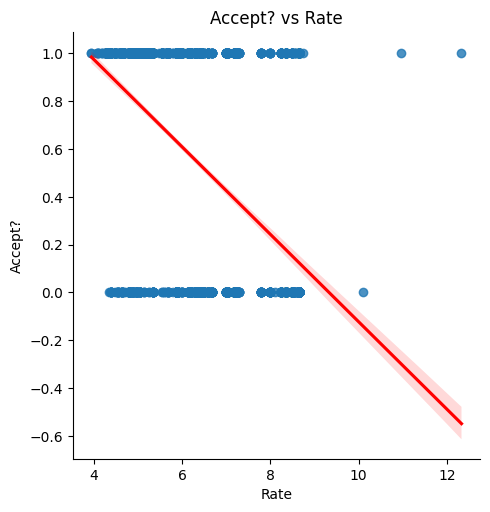

In [ ]:
# Scatterplot with trendline of Accept? vs Rate
sns.lmplot(x='Rate', y='Accept?', data=df, line_kws={'color': 'red'})
plt.title('Accept? vs Rate')
plt.show()

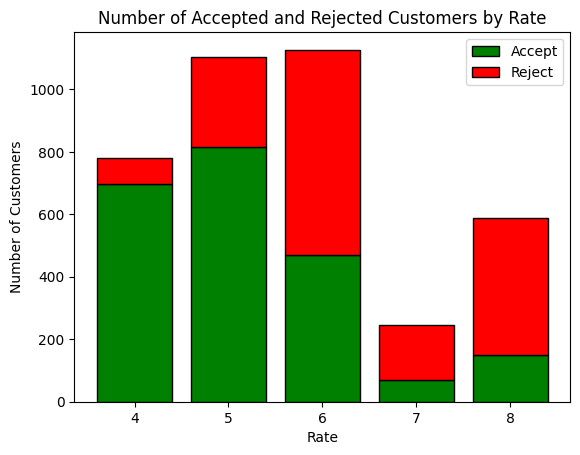

In [ ]:
# Compare the number of customers who accepted/rejected offers by rate
rate_reject = []
rate_accept = []

for r in range(4, 9):
  customers = df[(df['Rate'] >= r) & (df['Rate'] < r+1)]
  rate_reject.append(sum(customers['Accept?'] == 0))
  rate_accept.append(sum(customers['Accept?'] == 1))

plt.bar(range(4, 9), rate_accept, color='green', label='Accept', edgecolor='black')
plt.bar(range(4, 9), rate_reject, bottom=rate_accept, color='red', label='Reject', edgecolor='black')
plt.xlabel('Rate')
plt.ylabel('Number of Customers')
plt.title('Number of Accepted and Rejected Customers by Rate')
plt.legend()
plt.show()

As we increase the rate, we can see that less customers accept the loan (APR has a negative correlation to acceptance rate)

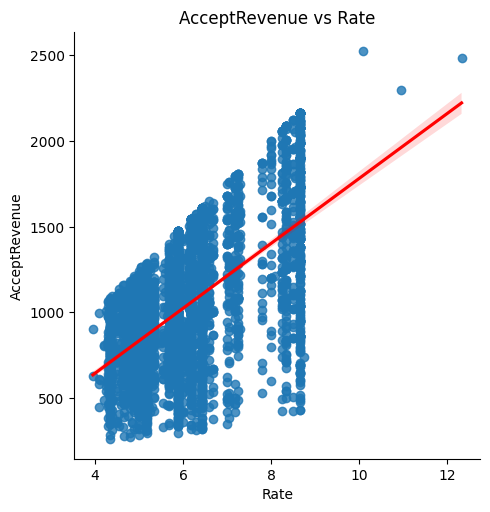

In [ ]:
# Scatterplot with trendline of AcceptRevenue vs Rate
sns.lmplot(x='Rate', y='AcceptRevenue', data=df, line_kws={'color': 'red'})
plt.title('AcceptRevenue vs Rate')
plt.show()

We can see a positive correlation between APR and AcceptRevenue

The plots show that as e-Car raises its quoted APR, the share of customers who accept the loan falls off sharply, but each funded loan generates more revenue. In other words, e-Car must trade off higher per-loan profit against a lower take-rate—pushing rates up boosts margin on each deal but costs volume, while cutting rates drives volume at the expense of per-loan revenue.

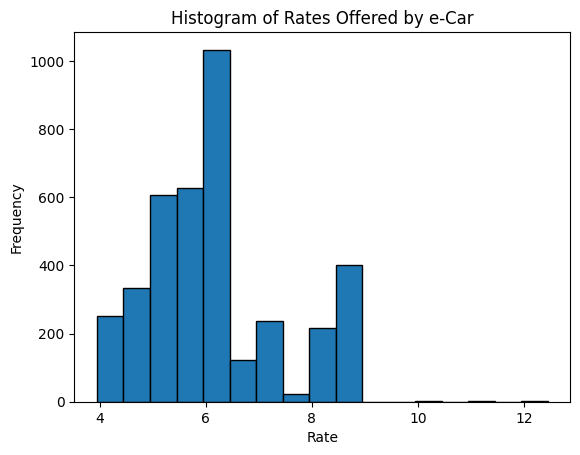

In [ ]:
# Histogram of the rates offered by e-Car
w = 0.5
bins = np.arange(df['Rate'].min(), df['Rate'].max() + w, w)
plt.hist(df['Rate'], bins=bins, edgecolor = 'black')
plt.title('Histogram of Rates Offered by e-Car')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()

We can see some outliers in our data (rates above 10%).

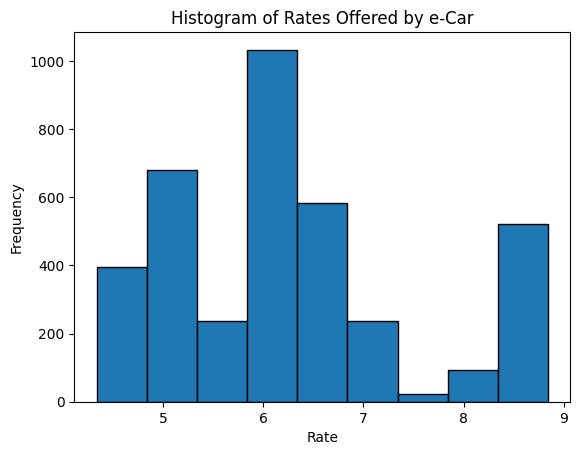

In [ ]:
# Remove the top 2% and bottom 2% for all subsequent analysis
lower_bound = df['Rate'].quantile(0.02)
upper_bound = df['Rate'].quantile(0.98)
df = df[(df['Rate'] >= lower_bound) & (df['Rate'] <= upper_bound)]

# Histogram for filtered dataset
new_bins = np.arange(df['Rate'].min(), df['Rate'].max() + w, w)
plt.hist(df['Rate'], bins=new_bins, edgecolor = 'black')
plt.title('Histogram of Rates Offered by e-Car')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()

According to the plot, ~6.15% is most commonly offered rate by eCar for this customer segment.

#Logistic Regression

In [ ]:
# Predict probability of acceptance using only the Rate feature
logit = LogisticRegression(penalty=None, solver='newton-cholesky')
logit.fit(df[['Rate']], df[['Accept?']])

df['ProbAccept'] = logit.predict_proba(df[['Rate']])[:,1]
df['ExpectedRevenue'] = df['ProbAccept'] * df['Rate'] * df['Amount'] / 100

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Check model performance
print("Accuracy:", logit.score(df[['Rate']], df[['Accept?']]))
print("AUC:", roc_auc_score(df[['Accept?']], logit.predict_proba(df[['Rate']])[:,1]))

Accuracy: 0.683311432325887
AUC: 0.7866932624113474


In [ ]:
print("Average of the expected revenue is", round(df['ExpectedRevenue'].mean(), 2))

Average of the expected revenue is 550.55


The average ExpectedRevenue is 550.55. This means that, on average across all applications, e-Car can expect to earn about $550.55 per loan offer when weighting each offer’s revenue by its predicted probability of acceptance.

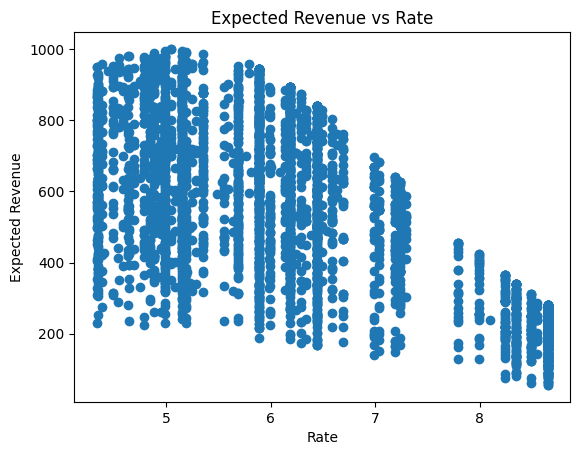

In [ ]:
plt.scatter(df['Rate'], df['ExpectedRevenue'])
plt.title('Expected Revenue vs Rate')
plt.xlabel('Rate')
plt.ylabel('Expected Revenue')
plt.show()

We can choose 5.1% as our alternative rate since it seems to have the highest expected revenue

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


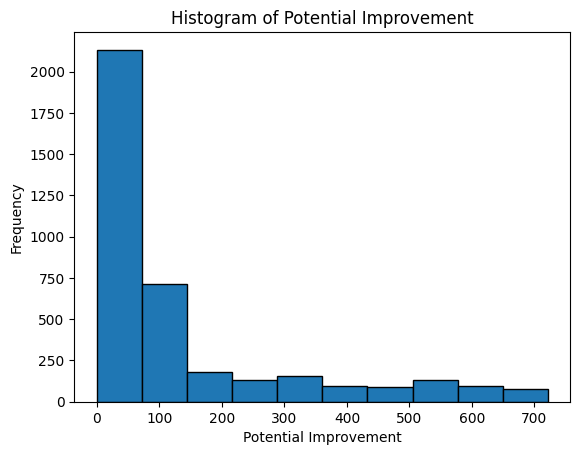

In [ ]:
# choose 5.1% as alternative rate
df['Potential Revenue'] = (logit.predict_proba([[5.1]])[:, 1]) * 5.1 * df['Amount'] / 100
df['Potential Improvement'] = df['Potential Revenue'] - df['ExpectedRevenue']

bins = np.arange(df['Potential Improvement'].min(), df['Potential Improvement'].max() + 0.5, 0.5)
plt.hist(df['Potential Improvement'], edgecolor='black')
plt.title('Histogram of Potential Improvement')
plt.xlabel('Potential Improvement')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Negative or no improvement:", (df['Potential Improvement'] <= 0).sum())
print("Positive improvement:", (df['Potential Improvement'] > 0).sum())
print("Average of potential expected revenue is", round(df['Potential Revenue'].mean(), 2))

Negative or no improvement: 0
Positive improvement: 3805
Average of potential expected revenue is 682.96


Quoting a flat 5.1% APR maximizes the model’s average expected revenue, lifting it from \$550.55 to \$682.96 per offer—a \$132.41 gain on average (every single application improved).

#Other Models

In [ ]:
# Split data into training, validation, and testing set
X = df[['FICO', 'Amount', 'Competition rate', 'Rate', 'Cost of Funds', 'Partner Bin']]
Y = df[['Accept?']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 1/3, random_state=120)

In [ ]:
# check if dataset is imbalanced
print("Accepted offer:", round(sum(df['Accept?'] == 1) / len(df), 3))
print("Rejected offer:", round(sum(df['Accept?'] == 0) / len(df), 3))

Accepted offer: 0.568
Rejected offer: 0.432


We don't see any significant imbalance in our data, indicating that we can use accuracy to measure our models' performances

##Support Vector Machine

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', svm.SVC())
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__gamma': [0.01, 0.1, 1, 10],
    'model__kernel': ['linear', 'rbf']
}

cv = KFold(n_splits=5, shuffle=True, random_state=40)
svm_grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
svm_grid.fit(X_train, Y_train)

clear_output()

print('Best parameters:', svm_grid.best_params_)
print('Best score:', svm_grid.best_score_)

Best parameters: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best score: 0.8103760809152337


In [ ]:
# Check performance
print("Training accuracy:", svm_grid.score(X_train, Y_train))
print("Validation accuracy:", svm_grid.score(X_val, Y_val))
print("Training AUC:", roc_auc_score(Y_train, svm_grid.predict(X_train)))
print("Validation AUC:", roc_auc_score(Y_val, svm_grid.predict(X_val)))

Training accuracy: 0.8253849042433345
Validation accuracy: 0.8002628120893561
Training AUC: 0.8258984678915555
Validation AUC: 0.7970464578515871


##Random Forest

In [ ]:
forest_model = RandomForestClassifier(random_state=40)

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': np.arange(5, 15)
}

cv = KFold(n_splits=5, shuffle=True, random_state=40)
forest_grid = GridSearchCV(forest_model, param_grid, cv=cv, scoring='roc_auc')
forest_grid.fit(X_train, Y_train)

clear_output()

print('Best parameters:', forest_grid.best_params_)
print('Best score:', forest_grid.best_score_)

Best parameters: {'max_depth': np.int64(6), 'n_estimators': 300}
Best score: 0.8944006109195787


In [ ]:
print("Training accuracy:", forest_grid.score(X_train, Y_train))
print("Validation accuracy:", forest_grid.score(X_val, Y_val))
print("Training AUC:", roc_auc_score(Y_train, forest_grid.predict(X_train)))
print("Validation AUC:", roc_auc_score(Y_val, forest_grid.predict(X_val)))

Training accuracy: 0.9260831334564054
Validation accuracy: 0.8932100063064957
Training AUC: 0.8452480699024477
Validation AUC: 0.8006691892649428


##K Nearest Neighbors

In [ ]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(5, 20)}

knn_grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
knn_grid.fit(X_train, Y_train)

clear_output()

print("Best parameters:", knn_grid.best_params_)
print("Best score:", knn_grid.best_score_)

Best parameters: {'knn__n_neighbors': np.int64(17)}
Best score: 0.8028657478593295


In [ ]:
print("Training accuracy:", knn_grid.score(X_train, Y_train))
print("Validation accuracy:", knn_grid.score(X_val, Y_val))
print("Training AUC:", roc_auc_score(Y_train, knn_grid.predict(X_train)))
print("Validation AUC:", roc_auc_score(Y_val, knn_grid.predict(X_val)))

Training accuracy: 0.8167480285392414
Validation accuracy: 0.7792378449408672
Training AUC: 0.8156302223122499
Validation AUC: 0.774441174409642


##ANN

In [ ]:
# Feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
tf.random.set_seed(9)

nn = Sequential()
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(8, activation='softmax'))

nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = nn.fit(X_train_scaled, Y_train, epochs=30, validation_data=(X_val_scaled, Y_val))

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4733 - loss: 1.5237 - val_accuracy: 0.7740 - val_loss: 0.5450
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7756 - loss: 0.4815 - val_accuracy: 0.7871 - val_loss: 0.4878
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.4345 - val_accuracy: 0.7963 - val_loss: 0.4764
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 0.4233 - val_accuracy: 0.7937 - val_loss: 0.4705
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8114 - loss: 0.4179 - val_accuracy: 0.7976 - val_loss: 0.4678
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.4149 - val_accuracy: 0.8003 - val_loss: 0.4663
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8072 - loss: 0.4129 - val_accuracy: 0.7989 - val_loss: 0.4653
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8097 - loss: 0.4113 - val_accuracy: 0.7976 - val_loss:

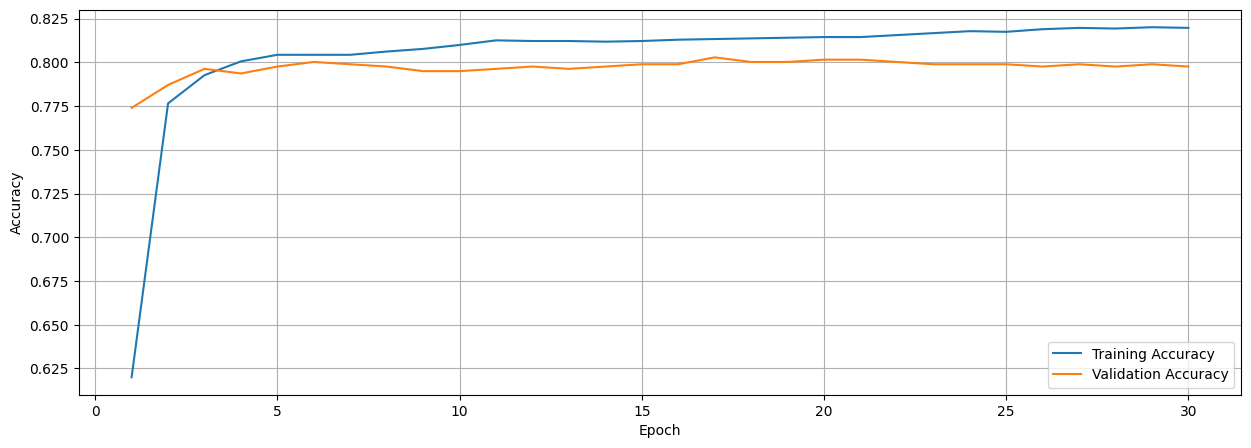

In [ ]:
# Find best epoch number
nepochs = 30
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, nepochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, nepochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

The best epoch number is 17 (highest validation accuracy)

In [ ]:
tf.random.set_seed(9)

nn_best = Sequential()
nn_best.add(Dense(64, activation='relu'))
nn_best.add(Dense(32, activation='relu'))
nn_best.add(Dense(8, activation='softmax'))

nn_best.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nn_best.fit(X_train_scaled, Y_train, epochs=17, validation_data=(X_val_scaled, Y_val))

Epoch 1/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3381 - loss: 1.6086 - val_accuracy: 0.7792 - val_loss: 0.5596
Epoch 2/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7889 - loss: 0.4870 - val_accuracy: 0.7898 - val_loss: 0.4908
Epoch 3/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.4371 - val_accuracy: 0.7924 - val_loss: 0.4795
Epoch 4/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 0.4263 - val_accuracy: 0.7950 - val_loss: 0.4746
Epoch 5/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8037 - loss: 0.4214 - val_accuracy: 0.7989 - val_loss: 0.4715
Epoch 6/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8069 - loss: 0.4186 - val_accuracy: 0.7950 - val_loss: 0.4696
Epoch 7/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8090 - loss: 0.4168 - val_accuracy: 0.7963 - val_loss: 0.4681
Epoch 8/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8088 - loss: 0.4154 - val_accuracy: 0.7937 - val_loss:

In [ ]:
y_train_pred = np.argmax(nn_best.predict(X_train_scaled), axis = 1)
y_val_pred = np.argmax(nn_best.predict(X_val_scaled), axis = 1)
y_test_pred = np.argmax(nn_best.predict(X_test_scaled), axis = 1)

print("Training accuracy:", accuracy_score(Y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(Y_val, y_val_pred))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training accuracy: 0.8216297408937289
Validation accuracy: 0.8015768725361366


We choose Random Forest model, which has the highest validation accuracy of 0.893.

In [ ]:
print("Test accuracy for Random Forest:", forest_grid.score(X_test, Y_test))

Test accuracy for Random Forest: 0.8810030820958251


In [ ]:
# Select a customer
customer = X_test.sample()
print(customer)

         FICO   Amount  Competition rate  Rate  Cost of Funds  Partner Bin
202939  700.0  11723.5              4.79  6.44           1.94          2.0


In [ ]:
# Calculate expected revenue for given customer
def compute_expected_revenue(customer):
  prediction = forest_grid.predict_proba(customer)[:, 1]
  expected_revenue = prediction * customer['Rate'].values * customer['Amount'].values / 100
  return expected_revenue

In [ ]:
# Vary the rate
rates = np.arange(4.0, 8.6, 0.1)
max_expected_revenue = 0
max_rate = 0

# Predict acceptance probability for each rate and calculate expected revenue
customer_new_rate = customer.copy()
for r in rates:
  customer_new_rate['Rate'] = r
  predicted_revenue = compute_expected_revenue(customer_new_rate)[0]
  if max_expected_revenue < predicted_revenue:
    max_expected_revenue = predicted_revenue
    max_rate = r

customer_expected_revenue = compute_expected_revenue(customer)[0]

print("Optimal rate:", round(max_rate, 2))
print("Maximum expected revenue:", round(max_expected_revenue,2), "\n")
print("Original rate:", customer['Rate'].values[0])
print("Original expected revenue:", round(customer_expected_revenue, 2), "\n")
print("Improvement:", round(max_expected_revenue - customer_expected_revenue, 2))


Optimal rate: 5.6
Maximum expected revenue: 538.05 

Original rate: 6.44
Original expected revenue: 361.52 

Improvement: 176.53


The optimal rate is different from the rate originally quoted to the customer. An optimal rate of 5.6% has an expected revenue of \$538.05, which is higher than the expected revenue of \$361.52 for the quoted rate 6.44% (\$176.53 improvement)

Our finding suggests that there's an opportunity to enhance revenue generation through the application of machine learning.

In [ ]:
import numpy as np
# Create a list to store the optimal rates and expected revenues for each customer
optimal_rates = []
optimal_revenues = []

# Iterate over each customer in the testing set
for index, customer in X_test.iterrows():
    # Vary the rate
    rates = np.arange(4.0, 8.6, 0.1)
    max_expected_revenue = 0
    max_rate = 0

    # Create a copy of the customer data
    customer_new_rate = customer.to_frame().T

    # Predict acceptance probability for each rate and calculate expected revenue
    for r in rates:
        customer_new_rate['Rate'] = r
        expected_revenue = compute_expected_revenue(customer_new_rate)[0]
        if max_expected_revenue < expected_revenue:
            max_expected_revenue = expected_revenue
            max_rate = r

    # Store the optimal rate and expected revenue
    optimal_rates.append(max_rate)
    optimal_revenues.append(max_expected_revenue)

# Calculate the total optimal revenue
total_optimal_revenue = sum(optimal_revenues)

# Calculate the total original revenue
# total_original_revenue = sum(X_test['Rate'] * X_test['Amount'] / 100)
total_original_revenue = sum(compute_expected_revenue(X_test))

# Calculate the total revenue improvement
total_revenue_improvement = total_optimal_revenue - total_original_revenue

print("Total optimal revenue:", total_optimal_revenue)
print("Total original revenue:", total_original_revenue)
print("Total revenue improvement:", total_revenue_improvement)


Total optimal revenue: 285254.10814413783
Total original revenue: 201305.30919722735
Total revenue improvement: 83948.79894691048


Total revenue can be improved by $83,948.80 by applying the optimal rates compared to the quoted rates

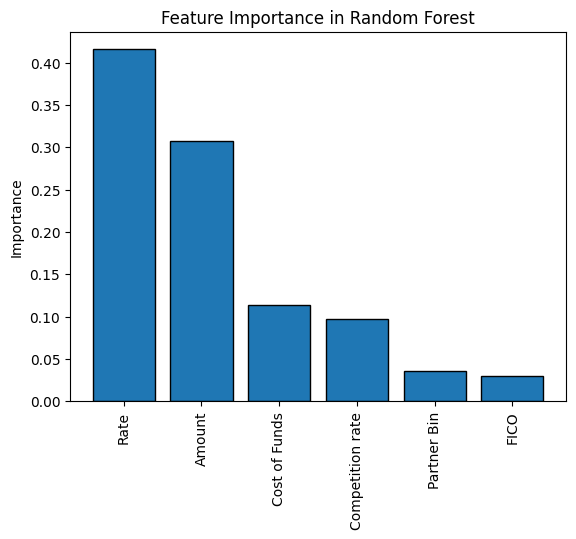

In [ ]:
# Feature importance

importance = forest_grid.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.bar(feature_importance['Feature'], feature_importance['Importance'], edgecolor='black')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

In our Random Forest, Rate and Loan Amounts dominate predictive power (more than 70% combined), where as Partner Bin and FICO contribute minimally to the prediction. It shows that focusing on Rate and Loan Amounts features during APR optimization will have the greatest impact. We can consider taking out Partner Bin and FICO if we want to reduce the size of our model or generalize it.

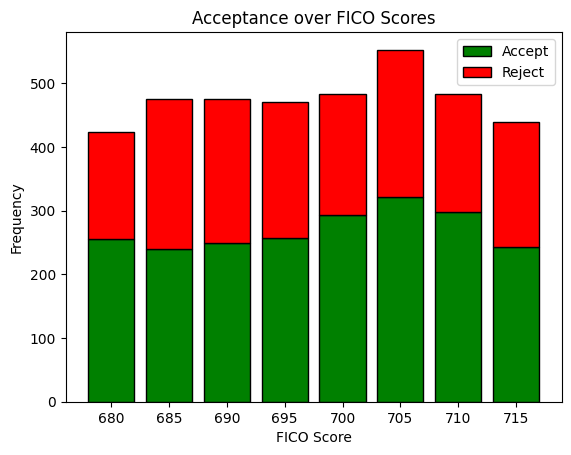

In [ ]:
# Compare acceptance rate for different FICO score
fico_accept, fico_reject = [], []

for f in range(680, 720, 5):
  customers = df[(df['FICO'] >= f) & (df['FICO'] < f+5)]
  fico_reject.append(sum(customers['Accept?'] == 0))
  fico_accept.append(sum(customers['Accept?'] == 1))

plt.bar(range(680, 720, 5), fico_accept, edgecolor='black', label='Accept', color='green', width=4)
plt.bar(range(680, 720, 5), fico_reject, bottom=fico_accept, edgecolor='black', label='Reject', color='red', width=4)
plt.title('Acceptance over FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Within 680-720 band, acceptance does not vary by finer FICO sub-ranges, so further subdiving this segment would increase complexity without improving model accuracy.

<ipython-input-61-9b29b505e807>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg['RateBin'] = seg['Rate'].round(1)


Text(0.5, 1.0, 'Take-Rate vs. APR by Loan Type')

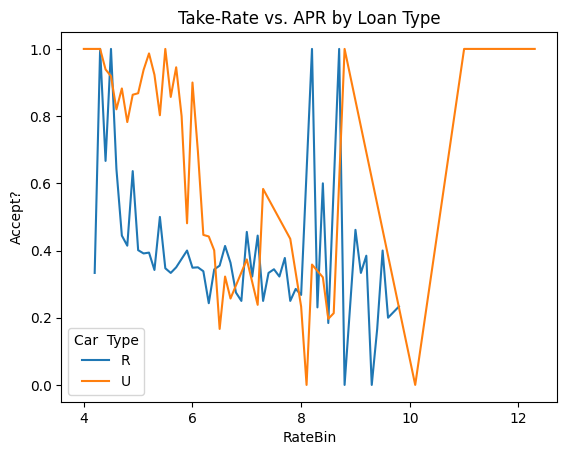

In [ ]:
seg = data_clean[(data_clean['Term']==60) &
         (data_clean['Amount']<25000) &
         (data_clean['FICO'].between(680,720)) &
         (data_clean['Car  Type'].isin(['U','R']))]

# Round the rate to nearest 0.1
seg['RateBin'] = seg['Rate'].round(1)

# For each car type and rate bin, calculate the take rate
rates = (seg
         .groupby(['Car  Type','RateBin'])['Accept?']
         .mean()
         .reset_index())

import seaborn as sns
sns.lineplot(data=rates, x='RateBin', y='Accept?', hue='Car  Type')
plt.title('Take-Rate vs. APR by Loan Type')

Higher Base Conversion: At a competitive APR (≈5 %), refinance applicants fund at ~90%, while purchase borrowers fund at ~80%

Gentler Decline: As APR climbs to 7–8 %, refinance take-rates remain above 60%, whereas purchase take-rates fall below 40%.

Wider “Price Cushion”: Refinance loans tolerate ~1% higher APR before volume drops off sharply compared to purchase loans.


In [ ]:
# Compute average loan amount
amt = seg.groupby(['Car  Type','RateBin'])['Amount'].mean().reset_index()
rev = rates.merge(amt, on=['Car  Type','RateBin'])

# Compute Expected Revenue
rev['ExpectedRev'] = rev['Accept?'] * rev['RateBin'] * rev['Amount'] / 100
peaks = rev.loc[rev.groupby('Car  Type')['ExpectedRev'].idxmax()]
print(peaks)

   Car  Type  RateBin  Accept?    Amount  ExpectedRev
43         R      8.7      1.0  19000.00   1653.00000
94         U     12.3      1.0  20151.18   2478.59514


Higher Base Conversion: At a competitive APR (≈5 %), refinance applicants fund at ~90%, while purchase borrowers fund at ~80%.​

Gentler Decline: As APR climbs to 7–8 %, refinance take-rates remain above 60%, whereas purchase take-rates fall below 40%.​


Wider “Price Cushion”: Refinance loans tolerate ~1% higher APR before volume drops off sharply compared to purchase loans.

We would recommend increasing refinance APRs by 0.5–1.0% relative to purchase deals.​ This will allow us to capture the extra margin from a segment that clearly values refinancing more highly without risking significant volume loss.

To deepen our study of e-Car’s business, we would broaden our data beyond the application fields to capture market, customer, and performance dynamics. First, we’d track the competitive landscape in real time—daily dealer and manufacturer promotional rates, geography-based incentives, and sudden rate cuts by rivals—so we can explicitly model how external pricing moves affect take-rates. Overlaying macroeconomic and regional indicators (local unemployment, income growth, consumer sentiment, and used-car price indices) would help us understand how economic swings influence both default risk and willingness to borrow.

At the borrower level, enriching profiles with employment history, income volatility measures, and “alternative” credit signals (e.g., rent and utility payment records or bank relationship data) would sharpen our risk estimates. Critically, we’d bring in post-funding performance metrics—time to delinquency, actual recovery values on repossessed vehicles, and prepayment or refinance behavior—to move from a simple approval model to a full customer-lifetime-value framework. Finally, integrating channel and marketing metrics (cost-per-acquisition by partner, website engagement and abandonment rates) and vehicle-specific data (mileage, telematics usage, resale forecasts) would enable more precise, segmented pricing. With these richer inputs, we could deploy survival models of default timing, sophisticated lifetime-value analyses, and stress-test scenarios under adverse economic conditions—ensuring that our pricing strategy remains profitable and resilient across market cycles.